# House Prices - Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs and gradient boosting

[Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

**Цель:**

Для каждого идентификатора в тестовом наборе необходимо предсказать значение переменной `SalePrice` (цену продажи дома)
.

**Метрика качества:**

Среднеквадратическая ошибка (RMSLE) между логарифмом прогнозируемого значения и логарифмом наблюдаемой продажной цены.

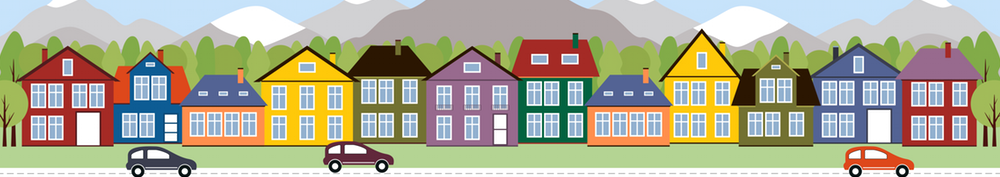

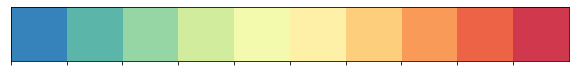

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

import scipy.stats as sps
from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score

import os
from tqdm import tqdm

custom_colors = sns.color_palette('Spectral_r', n_colors=10)
customPalette = sns.set_palette(sns.color_palette(custom_colors))

#set size
sns.palplot(sns.color_palette(custom_colors), size=1)

#Set up Screen output
pd.set_option('display.max_columns', 100)

# 1. Тщательный анализ данных.

### 1.0 Загрузка данных

Также выделим названия категориальных и числовых признаков в отдельные списки

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dirname = '/content/drive/MyDrive/Sber DS School/HW 5 (Kaggle. House Prices)/data'

In [ ]:
# train data
train_data = pd.read_csv(os.path.join(dirname, 'train.csv'), index_col='Id')
display(train_data.head(), train_data.shape)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(1460, 80)

In [ ]:
# test data
test_data = pd.read_csv(os.path.join(dirname, 'test.csv'), index_col='Id')
display(test_data.head(), test_data.shape)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


(1459, 79)

In [ ]:
# submission data
submission = pd.read_csv(os.path.join(dirname, 'sample_submission.csv'))
display(submission.head(), submission.shape)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


(1459, 2)

Число столбцов по типу

In [ ]:
train_data.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

Для нашего удобства создадим списки с именами категориальных и числовых колонок


In [ ]:
def select_cols_by_dtypes(df, dtypes):
    return df.select_dtypes(include=dtypes).columns.to_list()


# Категориальные признаки
cat_features = select_cols_by_dtypes(train_data, ['object'])
# Числовые признаки
num_features = select_cols_by_dtypes(train_data, ['int64', 'float64'])[:-1]
# Все признаки
feature_cols = num_features + cat_features
# Целевая переменная
target_col = 'SalePrice'

In [ ]:
X = train_data[feature_cols]
Y = train_data[target_col]
# После выделения названий признаков в список, порядок столбцов изменился
test_data = test_data[feature_cols]

# Соединим тренировочные и тестовые данные в одну таблицу
all_data = pd.concat((X, test_data)).reset_index(drop=True)

### 1.1 Исследование данных на наличие пропусков и некорректных значений. 

**Либо удалим их, либо сделаем imputing (проинтерполируем).**

Данные могут иметь пропущенные значения не случайно, а в виду некоторых закономерностей. В таких случаях пропуски можно выразить на основе информации, содержащейся в наборе данных. Благодаря описанию данных, приложенных к соревнованию, можно заменить их подходящими значениями.

#### Категориальные признаки

In [ ]:
def missing_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Считает число пропусков в каждой колонке

    :param df: данные для подсчёта пропусков
    
    :return: результаты подсчета
    """
    nans_count = df.isnull().sum().sort_values(ascending=False)
    nans_count = nans_count[nans_count > 0]
    percentage = (nans_count / df.shape[0]) * 100

    return pd.DataFrame({'Total': nans_count.values, 
                         'Percentage': percentage}, 
                        index=nans_count.index.values)

In [ ]:
# Информация о пропусках в категориальных признаках
cat_feature_nans = missing_data(all_data[cat_features])
cat_feature_nans.head()

,Total,Percentage
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797


In [ ]:
def plot_missing_distribution(df: pd.DataFrame, xlabel="Признаки"):
    """
    Визуализирует распределение пропусков по признакам

    :param df: информация о пропусках
    :param xlabel: название оси X 
    """
    plt.figure(figsize=(15, 7))

    sns.barplot(x=df.index, y=df['Percentage'], 
                alpha=1, edgecolor="k", linewidth=1, palette="Spectral_r")
    plt.xticks(rotation=30)
    plt.title('Распределение пропусков по признакам', fontsize = 22)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('Доля пропусков, %', fontsize=16)
    
    plt.show()

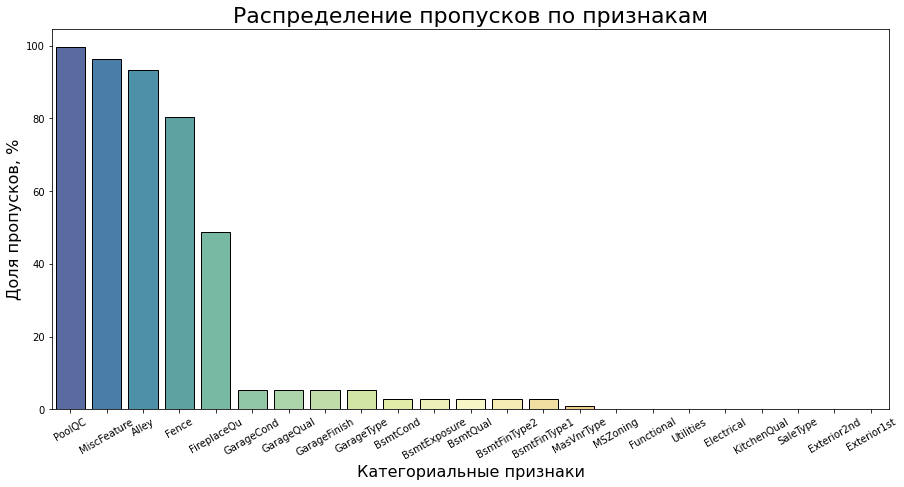

In [ ]:
plot_missing_distribution(cat_feature_nans, xlabel="Категориальные признаки")

Среди категориальных признаков есть колонки, где много пропущенных значений ${(> 80 \%)}$. Нет смысла заменять их, поэтому просто удалим эти столбцы: `PoolQC`, `MiscFeature`, `Alley`, `Fence`.

In [ ]:
for drop_col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence']:
    cat_features.remove(drop_col)

# обновим списков признаков
feature_cols = num_features + cat_features

X = X[feature_cols]
test_data = test_data[feature_cols]
all_data = all_data[feature_cols]

Посмотрим на распределение каждого категориального признака. 

Эта информация может помочь нам при заполнении пропусков.

In [ ]:
print("Число категориальных признаков:", len(cat_features))

Число категориальных признаков: 39


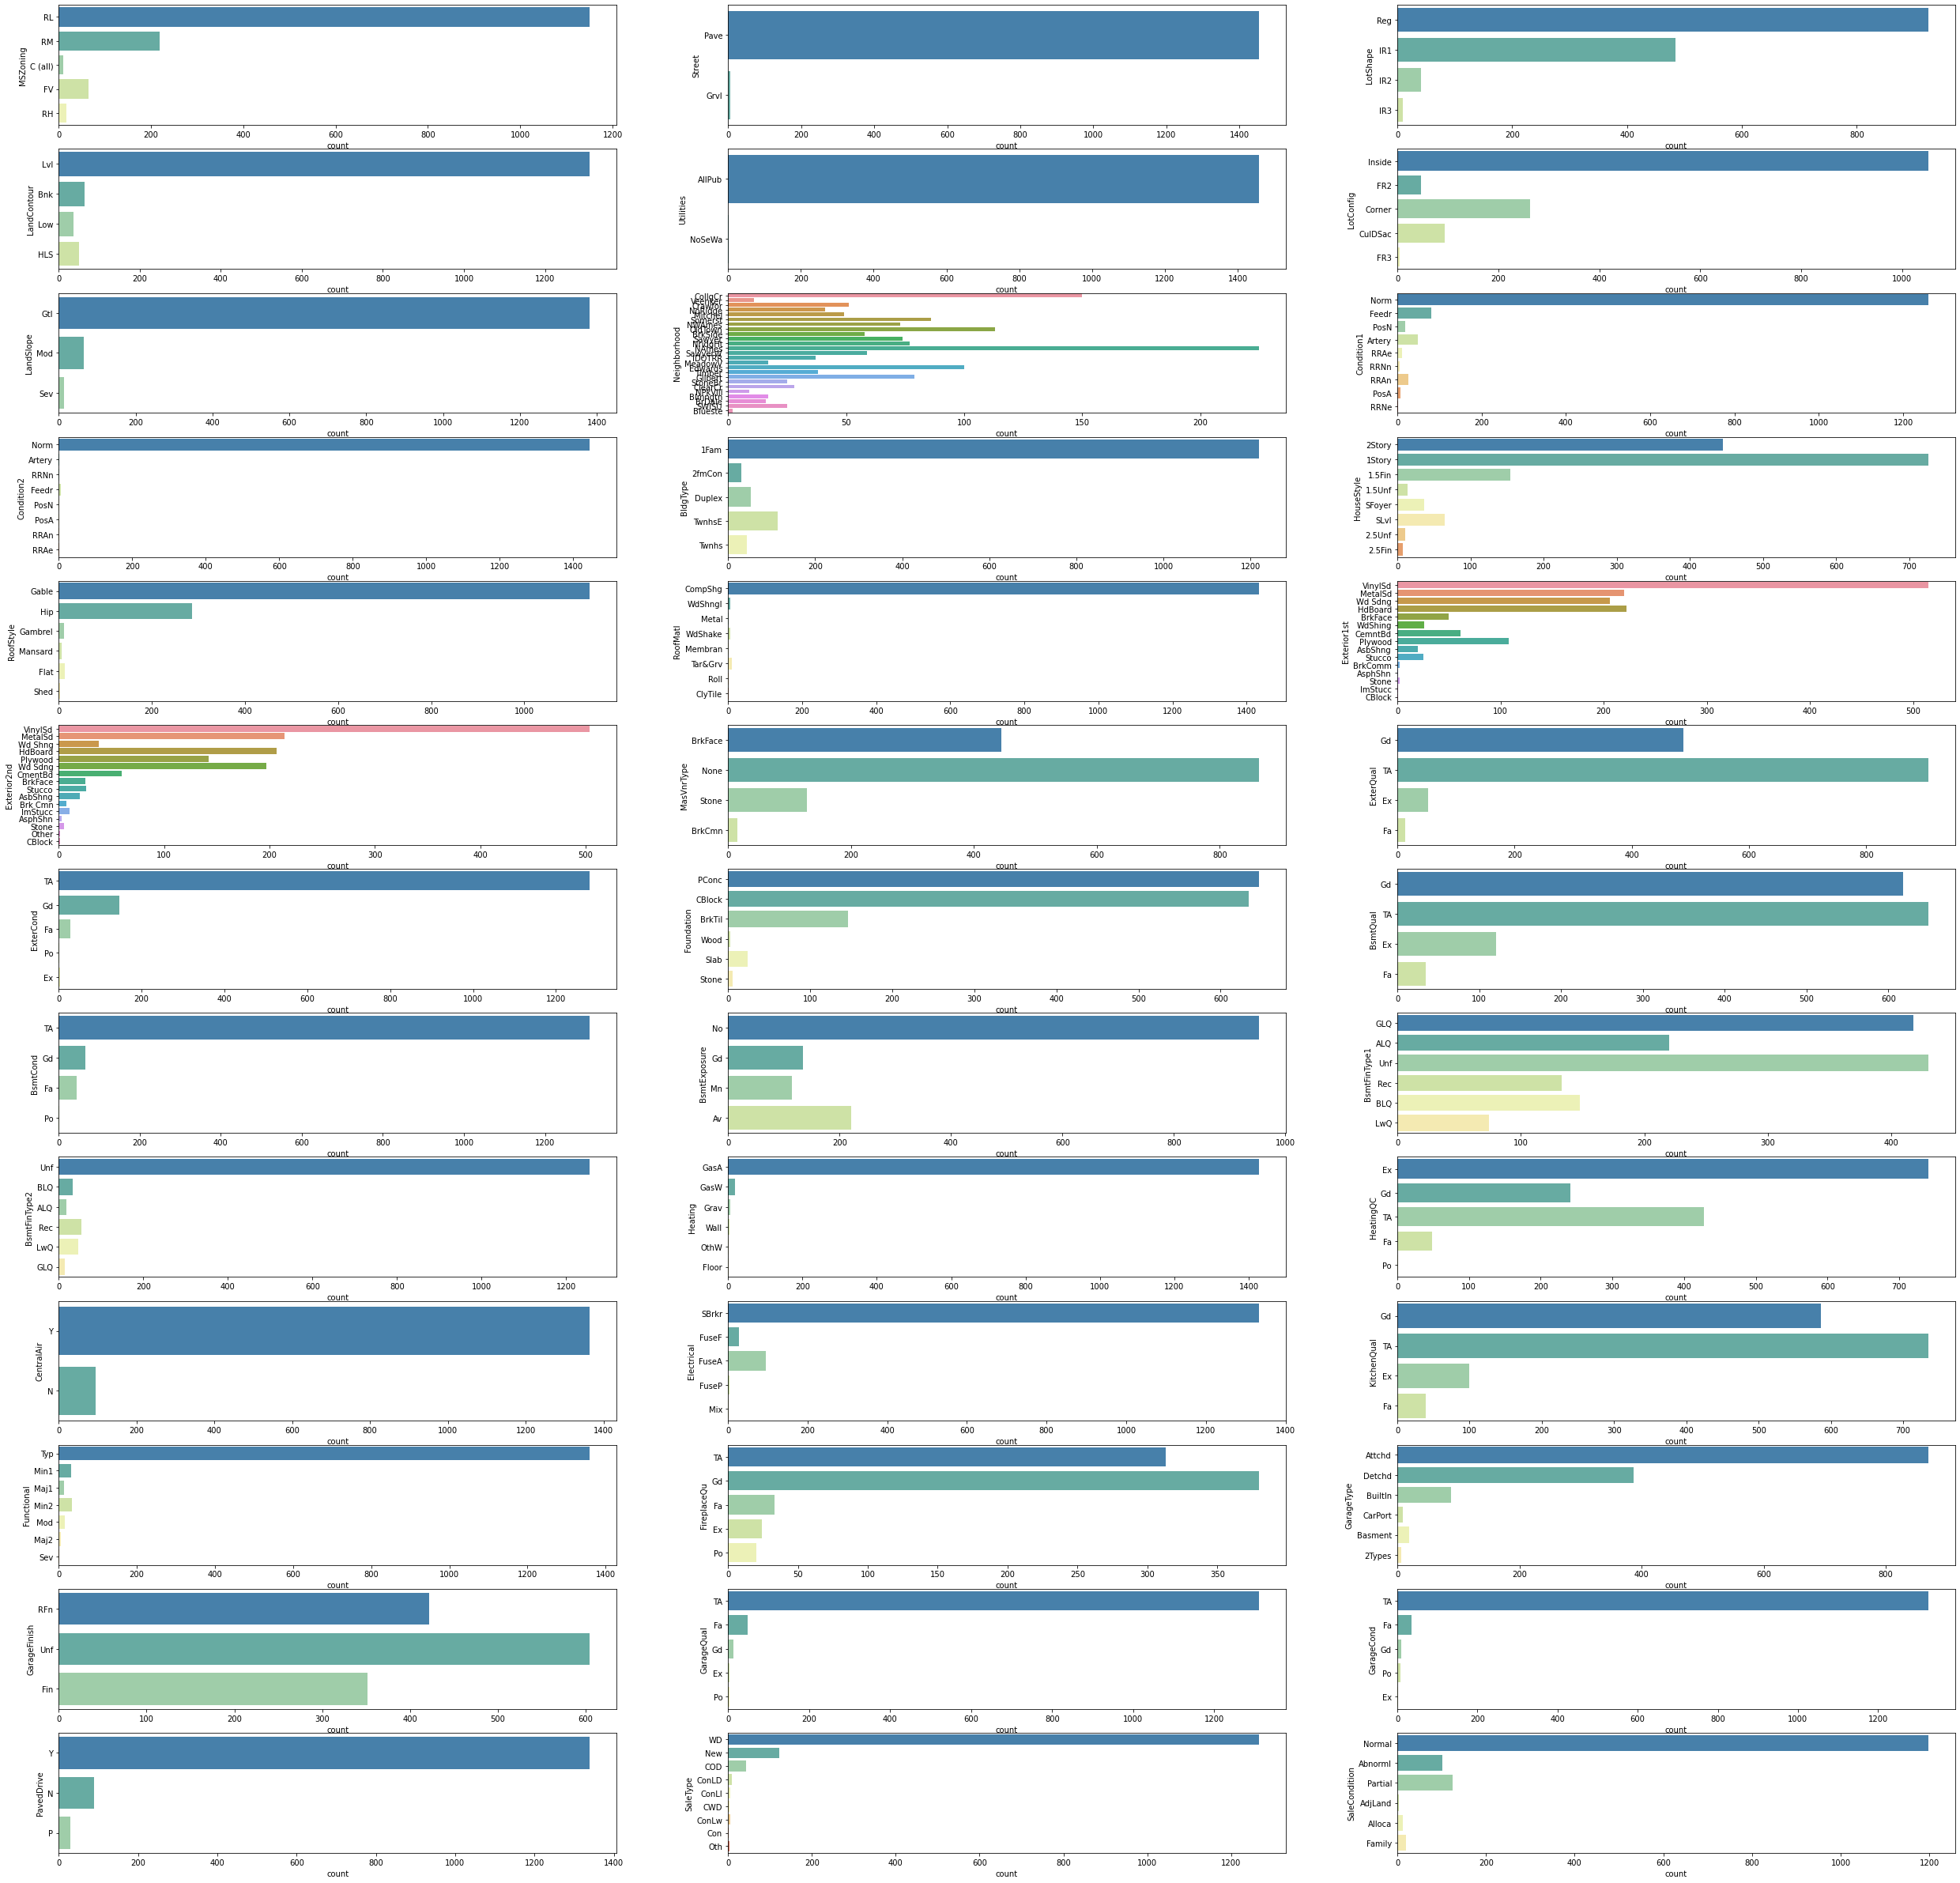

In [ ]:
fig, ax = plt.subplots(13, 3, figsize=(43, 43))

for i, col in enumerate(cat_features):
    sns.countplot(y=train_data[col], ax=ax.reshape(-1)[i])

plt.show()

Удалим неинформативные признаки `Utilities` и `Street`

In [ ]:
display(all_data.Utilities.value_counts(), all_data.Street.value_counts())

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

Pave    2907
Grvl      12
Name: Street, dtype: int64

In [ ]:
for drop_col in ["Utilities", "Street"]:
    cat_features.remove(drop_col)

# обновим списков признаков
feature_cols = num_features + cat_features

X = X[feature_cols]
test_data = test_data[feature_cols]
all_data = all_data[feature_cols]

In [ ]:
print("Число категориальных признаков:", len(cat_features))

Число категориальных признаков: 37


#### Разобьём данные на training sample и validation sample. 

**Для воспроизводимости выставим random_seed=2021. Размер валидационной выборки -- 20% от датасета.**

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y,
                                                      test_size=0.20,
                                                      random_state=2021)

Заполним пропуски в категориальных признаках.

In [ ]:
def simple_imputer(transform_params):
    """
    Предобрабатывает признаки по указанной стратегии sklearn.impute.SimpleImputer
    
    :param transform_params: список столбов и способ их обработки 
    (имена столбцов, объект SimpleImputer)
    """
    for param in transform_params:
        cols, imputer = list(param[:-1]), param[-1]

        # Data preparation without data leakage using cross-validation
        X[cols] = imputer.fit_transform(X[cols])
        test_data[cols] = imputer.transform(test_data[cols])

        # Train-Test Evaluation With Correct Data Preparation
        X_train[cols] = imputer.fit_transform(X_train[cols])
        X_valid[cols] = imputer.transform(X_valid[cols])

In [ ]:
categorical_transform_params = [
    # 'NA' и 'None' (из описания данных) говорят об отсутствии этих категорий у домов.
    # Например то, что у дома нет гаража характеризуется значением 'NA'.
    ('FireplaceQu', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType',
     'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 
     SimpleImputer(strategy='constant', fill_value='NA')),
    ('MasVnrType', SimpleImputer(strategy='constant', fill_value='None')),
    # Заполним модой, т.к. в данных очень мало пропусков и есть чётко преобладающее значение
    ('MSZoning', SimpleImputer(strategy='most_frequent')),
    # 'Typ' по описанию данных говорит о типичности признака (Typical Functionality)
    ('Functional', SimpleImputer(strategy='constant', fill_value='Typ')),
    # Заполним модой, т.к. в данных очень мало пропусков и есть чётко преобладающее значение
    ('Electrical', 'KitchenQual', 'SaleType', 'Exterior2nd', 'Exterior1st', 
     SimpleImputer(strategy='most_frequent'))
]

simple_imputer(categorical_transform_params)

#### Числовые признаки

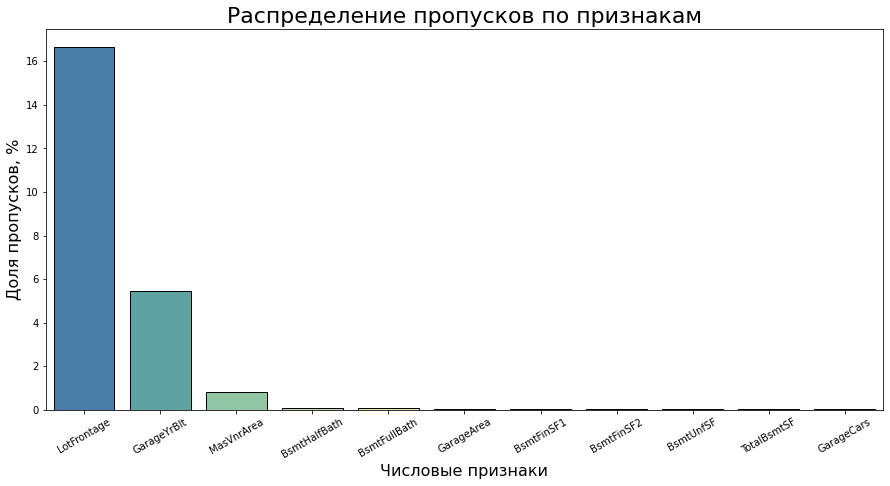

In [ ]:
# Информация о пропусках в числовых признаках
numerical_feature_nans = missing_data(all_data[num_features])
plot_missing_distribution(numerical_feature_nans, xlabel="Числовые признаки")

Обработаем пропуски

In [ ]:
def fill_median_each_neighboorhood(df):
    """
    Заполняет LotFrontage медианным значением по каждой группе в категории Neighborhood
    
    :param df: датафрейм для обработки
    """
    df['LotFrontage'] = df[['Neighborhood', 'LotFrontage']]\
                            .groupby('Neighborhood', as_index=False)['LotFrontage']\
                            .transform(lambda x: x.fillna(x.median()))


for x in [X, test_data, X_train, X_valid]:
    fill_median_each_neighboorhood(x)

In [ ]:
num_transform_params = [
    # В описании данных указано, что '0' для этих значений означает отсутствие категории у дома.
    # Например, если у дома нет гаража, то год построения 'GarageYrBlt' равен 0.
    ('GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'GarageArea',
     'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars',
     SimpleImputer(strategy='constant', fill_value=0))
]

simple_imputer(num_transform_params)

**Посмотрим на результат обработки пропущеных значений.**

Как видно, больше у нас не осталось пропусков. Все пропуски либо были заменены на разумные значения, либо удалены. Мы удалили всего 6 колонок: `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `Utilities`, `Street` (категориальные)

In [ ]:
display(missing_data(X), missing_data(test_data), 
        missing_data(X_train), missing_data(X_valid))

,Total,Percentage


,Total,Percentage


,Total,Percentage


,Total,Percentage


### 1.2 Распределение целевой переменной. Поиск аномалий.

**Можно убрать выбросы из датасета или преобразовать целевую переменную (например, посредством преобразования Бокса-Кокса).**

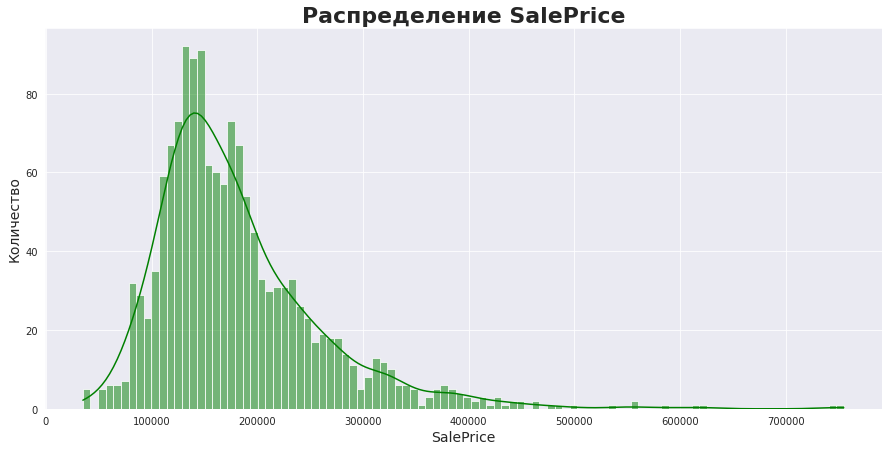

In [ ]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(15,7))
    sns.histplot(data=Y, bins=100, kde=True, color="Green")
    plt.title("Распределение SalePrice", fontsize = 22, fontweight="bold")
    plt.xlabel("SalePrice", fontsize=14)
    plt.ylabel('Количество', fontsize=14)

In [ ]:
Y, lambda_boxcox = sps.boxcox(Y)
Y = pd.Series(Y, name=target_col)

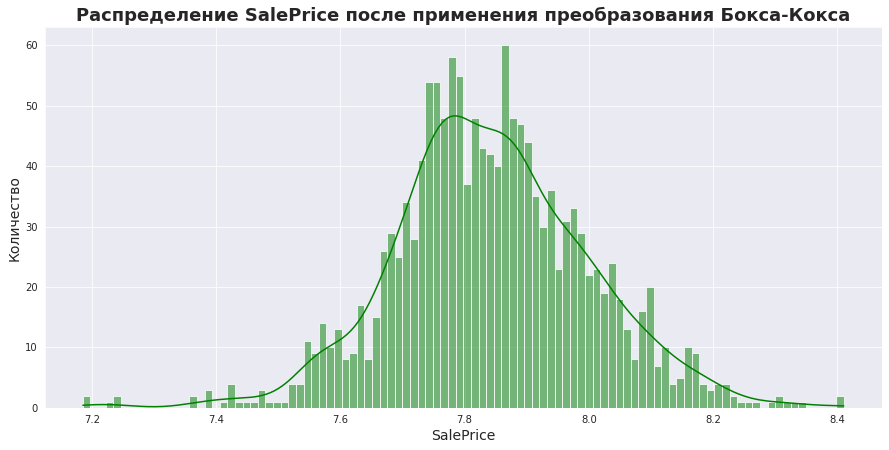

In [ ]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(15,7))
    sns.histplot(data=Y, bins=100, kde=True, color="Green")
    plt.title("Распределение SalePrice после применения преобразования Бокса-Кокса", 
              fontsize = 18, fontweight="bold")
    plt.xlabel("SalePrice", fontsize=14)
    plt.ylabel('Количество', fontsize=14)

In [ ]:
Y_train, Y_valid = train_test_split(Y, test_size=0.20, random_state=2021)

### 1.3 Проанализировать признаки. 

**Отобрать те, которые лично вам кажутся наиболее важными. Посмотреть на их распределение (в том числе на попарные). Посмотреть на совместное распределение целевой переменной и выбранных признаков.**

Построим матрицу корреляции для числовых данных, используя коэффициент корреляции Спирмена.

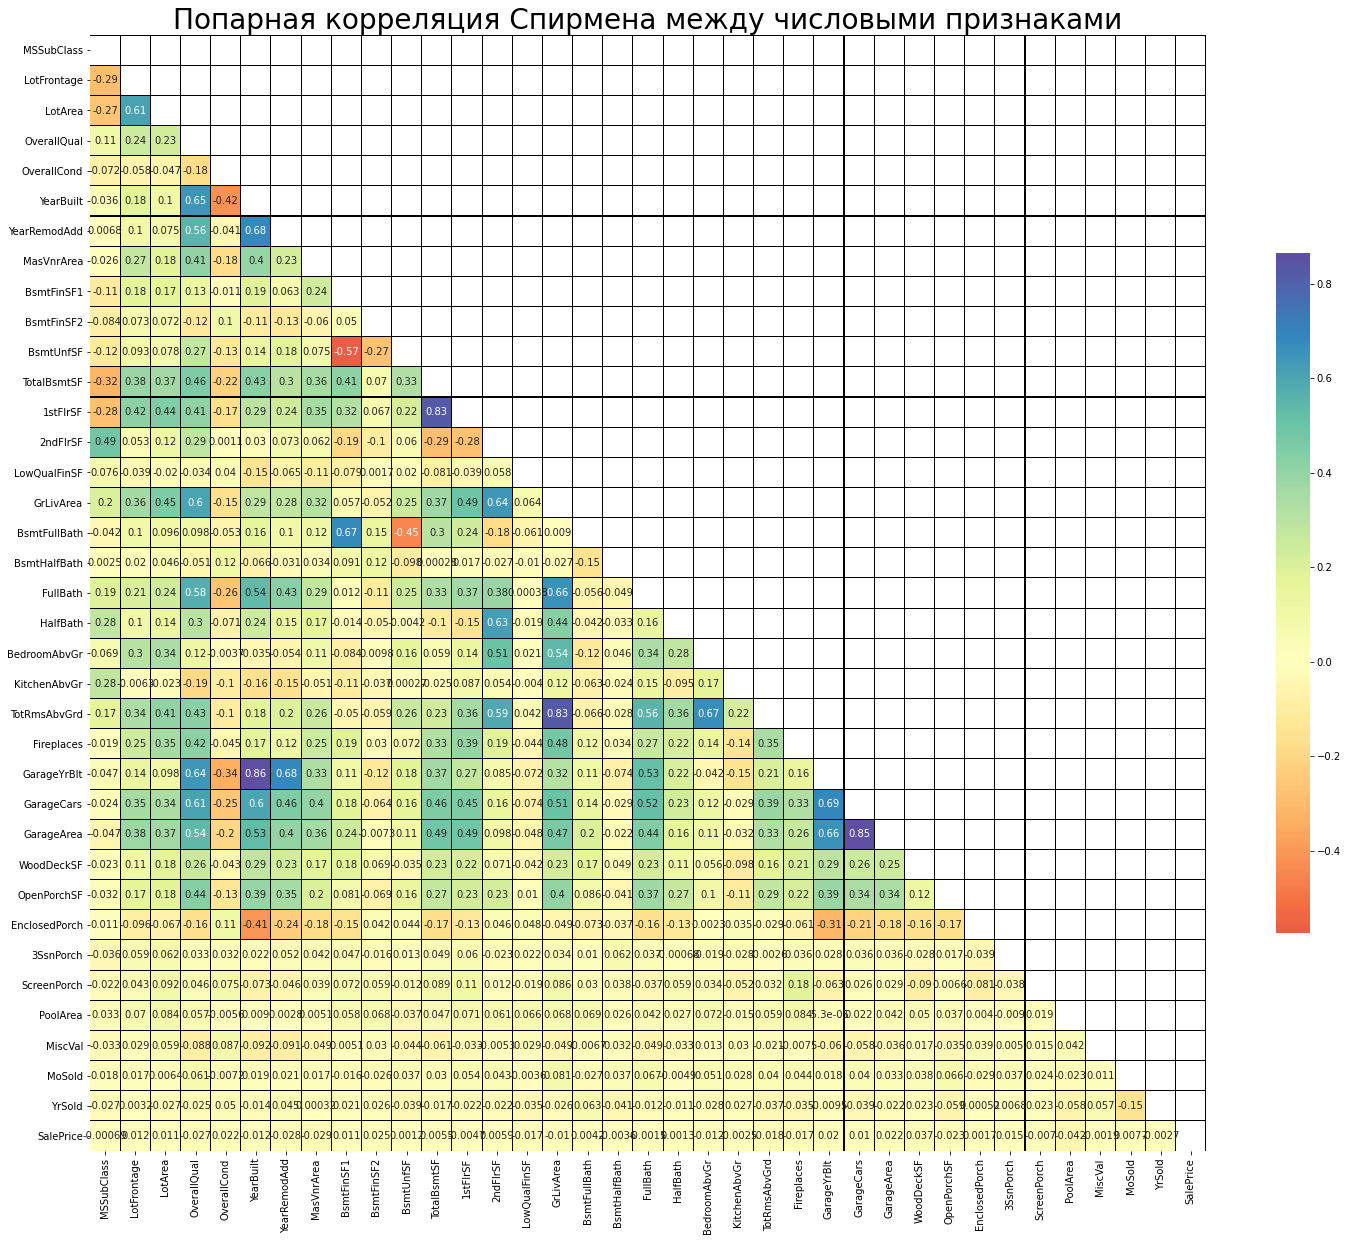

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

corr_matrix = pd.concat((X[num_features], Y), axis=1).corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, cmap="Spectral", 
            center=0, linewidths=0.05, linecolor="black", 
            annot=True, square=True, cbar_kws={"shrink": 0.5})
plt.title("Попарная корреляция Спирмена между числовыми признаками", fontsize=28)

plt.show()

### 1.4 Сформулировать гипотезы о том, какие сочетания признаков могут быть полезны. Добавить их (если придумаю). 

Отрисовать выборку на карте, посчитать расстояние до важных объектов в этом городе, посчитать статистики по районам и по ближайшим объектам (не забыть, что эти статистики нужно считать по обучающей выборке!).    

### 1.5 Исследовать зависимость целевой переменной от признаков, отобранных на предыдущем шаге, используя корреляционный анализ. 

Использовать scipy.stats.spearmanr для вещественных признаков, scipy.stats.pointbiserialr для бинарных признаков, scipy.stats.chisquare для прочих категориальных признаков (основная гипотеза -- равномерное распределение целевой переменной по значениям категориального признака). Выводы делать на основании p-value.

# 2. Правильная подготовка данных для обучения.

## 2.1 Разбить данные на training sample и validation sample. 

**Не забыть выставить random_seed=2021. Размер валидационной выборки -- 20% от датасета.**

In [ ]:
# Выполнено на стадии предобработки данных

## 2.2 Убедимся, что распределение целевой переменной (хотя бы её) на обучающей и валидационной выборках совпадают.

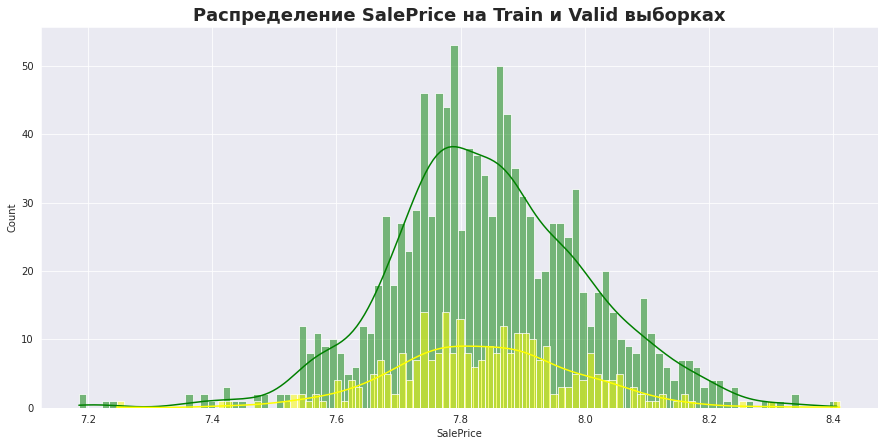

In [ ]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(15,7))
    sns.histplot(data=Y_train, bins=100, kde=True, color="Green")
    sns.histplot(data=Y_valid, bins=100, kde=True, color="Yellow")
    plt.title("Распределение SalePrice на Train и Valid выборках", 
              fontsize=18, fontweight="bold")

# 3. Обоснованный выбор алгоритма и его гиперпараметров.

Рекомендуемое решение: использовать catboost.CatBoostRegressor или sklearn.ensemble.RandomForest. Нейросети вряд ли покажут более высокое качество, но пробовать не возбраняется. Можно использовать линейные модели, если вы умеете ими пользоваться и уверены, что они уместны в этой задаче. 

Если гиперпараметры подбирались, нужно обосновать необходимость в этом.

Учесть логику работы алгоритма. Не нужно делать one-hot encoding категориальных признаков при использовании CatBoostRegressor, нужно масштабировать признаки при работе с метрическими методами etc.

In [ ]:
!pip install -q catboost
from catboost import CatBoostRegressor

In [ ]:
# catboost_train_dataset = Pool(
#     data=X_train,
#     label=Y_train,
#     cat_features=cat_cols,
#     feature_names=list(feature_cols)
# )

# searching_model = CatBoostRegressor(
#     random_state=2021
# )

# grid = {'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = searching_model.grid_search(grid, X=catboost_train_dataset, 
#                                                  verbose=200, plot=True)

# catboost_params = {
#     'depth': 4,
#     'l2_leaf_reg': 1,
#     'verbose': 250,
#     'random_seed': 2021
# }
# catboost_model = CatBoostRegressor(**catboost_params)
# catboost_model = catboost_model.fit(
#     X_train, Y_train,
#     cat_features=cat_cols,
#     eval_set=(X_valid, Y_valid),
#     use_best_model=True
# )

# print(catboost_model.score(X_valid, Y_valid))

In [ ]:
from sklearn.model_selection import KFold


catboost_params = {
    'depth': 4,
    'l2_leaf_reg': 1,
    'verbose': 250,
    'random_seed': 2021
}

kf = KFold(n_splits=5)
scores = []
Y_predict = []

for train_index, test_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_valid = Y.iloc[train_index], Y.iloc[test_index]

    model = CatBoostRegressor(**catboost_params)
    model = model.fit(X_train, Y_train,
                      cat_features=cat_features,
                      eval_set=(X_valid, Y_valid),
                      use_best_model=True)
    
    scores.append(model.score(X_valid, Y_valid))
    Y_predict.append(inv_boxcox(model.predict(test_data), lambda_boxcox))

0:	learn: 0.1563621	test: 0.1499880	best: 0.1499880 (0)	total: 62.7ms	remaining: 1m 2s
250:	learn: 0.0441725	test: 0.0464493	best: 0.0464493 (250)	total: 3.23s	remaining: 9.64s
500:	learn: 0.0365157	test: 0.0442450	best: 0.0441705 (491)	total: 6.4s	remaining: 6.37s
750:	learn: 0.0324703	test: 0.0440428	best: 0.0438501 (692)	total: 9.55s	remaining: 3.17s
999:	learn: 0.0295372	test: 0.0442982	best: 0.0438501 (692)	total: 12.8s	remaining: 0us

bestTest = 0.04385010744
bestIteration = 692

Shrink model to first 693 iterations.
0:	learn: 0.1526814	test: 0.1660329	best: 0.1660329 (0)	total: 13.1ms	remaining: 13s
250:	learn: 0.0431294	test: 0.0565483	best: 0.0565483 (250)	total: 3.22s	remaining: 9.61s
500:	learn: 0.0368696	test: 0.0539045	best: 0.0539045 (500)	total: 6.4s	remaining: 6.38s
750:	learn: 0.0327619	test: 0.0532501	best: 0.0531795 (732)	total: 9.63s	remaining: 3.19s
999:	learn: 0.0297213	test: 0.0530312	best: 0.0529949 (980)	total: 12.9s	remaining: 0us

bestTest = 0.05299491732
bes

In [ ]:
mean_score = np.mean(scores)
Y_predict = np.mean(Y_predict, axis=0)
print(mean_score)

0.903617027852792


In [ ]:
submission[target_col] = Y_predict
submission.to_csv(dirname + '/my_submission.csv', index=False)

# 4. Предсказания.

In [ ]:
# best_model = catboost_model

In [ ]:
# submission[target_col] = inv_boxcox(best_model.predict(test_data[feature_cols]), lambda_boxcox)
# submission.to_csv(dirname + '/my_submission.csv', index=False)

In [ ]:
submission

,Id,SalePrice
0,1461,116832.738582
1,1462,155834.160234
2,1463,183569.089136
3,1464,193081.167981
4,1465,188666.029598
...,...,...
1454,2915,84640.647086
1455,2916,83352.895702
1456,2917,160073.816321
1457,2918,116123.787723


# 5. Post-hoc анализ.

### 5.1 Проанализировать важности признаков (рекомендуется использовать SHAP-values.

### 5.2 Соотнести полученную из модели важность признаков с гипотезами из пункта 1. Пояснить расхождения.

### 5.3 Сравнить распределение ошибок вашей первой и лучшей посылок при помощи теста Манна-Уитни (в том виде, в каком он был на лекции! В scipy.stats реализован тест для проверки гипотезы сдвига, а вас интересует гипотеза доминирования). Убедиться, что лучшая модель объективно лучше.

In [ ]:
!pip install -q shap

In [ ]:
import shap

explainer = shap.Explainer(catboost_model)
shap_values = explainer.shap_values(X_train)


shap.summary_plot(shap_values, X_train)

In [ ]:
sorted(list(zip(feature_cols, 
                catboost_model.feature_importances_.tolist())), 
       key=lambda x: -x[1]
)
